In [1]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from typing import List, Tuple
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
from typing import List, Tuple
from sklearn.metrics import f1_score

In [3]:
# Preprocessing class for handling text data
class TextPreprocessor:
    def __init__(self, max_len: int = 100):
        self.max_len = max_len
        self.vocab = {'<PAD>': 0, '<UNK>': 1}  # Initial vocabulary with padding and unknown tokens
        self.vocab_size = 2
    
    def tokenize(self, text: str) -> List[str]:
        """Tokenize HTML text into meaningful components."""
        # Separate HTML tags and attributes
        text = re.sub(r'([<>/="])', r' \1 ', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text.lower().split()
    
    def build_vocab(self, texts: List[str], min_freq: int = 2):
        """Build vocabulary with common tokens"""
        counter = Counter()
        for text in texts:
            tokens = self.tokenize(text)
            counter.update(tokens)
        
        # Add words meeting the minimum frequency threshold
        for word, freq in counter.items():
            if freq >= min_freq and word not in self.vocab:
                self.vocab[word] = self.vocab_size
                self.vocab_size += 1
    
    def encode_text(self, text: str) -> List[int]:
        """Convert text to integer sequence"""
        tokens = self.tokenize(text)
        # Truncate or pad to specified length
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            tokens.extend(['<PAD>'] * (self.max_len - len(tokens)))
        
        return [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]


In [4]:
# Custom Dataset class for XSS data
class XSSDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], preprocessor: TextPreprocessor):
        self.preprocessor = preprocessor
        self.encodings = [self.preprocessor.encode_text(text) for text in texts]
        self.labels = labels
        self.has_printed = False

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        if idx < 3 and not self.has_printed:
            print(f"Preprocessed input {idx}: {self.encodings[idx]}")
            self.has_printed = True
        return (torch.tensor(self.encodings[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.float))

In [5]:
# LSTM model class for XSS detection
class XSSDetectorLSTM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int = 50, 
                 hidden_dim: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        self.fc1 = nn.Linear(hidden_dim * 2, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Use the last time step's hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.dropout(hidden)
        out = torch.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out

In [6]:
# Detector class to handle training and prediction
class XSSDetector:
    def __init__(self, max_len: int = 100, device: str = None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.max_len = max_len
        self.preprocessor = TextPreprocessor(max_len)
        self.model = None
        self.training_losses = []
        self.validation_losses = []
    
    def train(self, texts: List[str], labels: List[int], 
              epochs: int = 20, batch_size: int = 32, learning_rates: List[float] = [0.001, 0.002, 0.01, 0.02, 0.05],
              val_split: float = 0.1):
        
        # Build vocabulary and create dataset as before...
        self.preprocessor.build_vocab(texts)
        dataset = XSSDataset(texts, labels, self.preprocessor)
        
        # Split dataset and create loaders...
        val_size = int(len(dataset) * 0.2)
        test_size = int(len(dataset) * 0.1)
        train_size = len(dataset) - val_size - test_size

        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size, test_size]
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        # Initialize model...
        self.model = XSSDetectorLSTM(
            vocab_size=self.preprocessor.vocab_size,
            embedding_dim=50
        ).to(self.device)
        
        for lr in learning_rates:
            print(f"Training with learning rate: {lr}")

            optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
            criterion = nn.BCELoss()

            
            # Lists to store losses
            self.training_losses = []
            self.validation_losses = []
            
            # Training loop
            for epoch in range(epochs):
                self.model.train()
                total_loss = 0
                correct = 0
                total = 0
                
                for batch_sequences, batch_labels in train_loader:
                    batch_sequences = batch_sequences.to(self.device)
                    batch_labels = batch_labels.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.model(batch_sequences).squeeze()
                    loss = criterion(outputs, batch_labels)
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                    
                    predictions = (outputs >= 0.5).float()
                    correct += (predictions == batch_labels).sum().item()
                    total += len(batch_labels)
                
                # Calculate average training loss for this epoch
                avg_train_loss = total_loss / len(train_loader)
                self.training_losses.append(avg_train_loss)
                
                # Validation
                self.model.eval()
                val_loss = 0
                val_correct = 0
                val_total = 0
                val_predictions = []
                val_true_labels = []

                with torch.no_grad():
                    for batch_sequences, batch_labels in val_loader:
                        batch_sequences = batch_sequences.to(self.device)
                        batch_labels = batch_labels.to(self.device)
                        
                        outputs = self.model(batch_sequences).squeeze()
                        val_loss += criterion(outputs, batch_labels).item()
                        
                        predictions = (outputs >= 0.5).float()
                        val_correct += (predictions == batch_labels).sum().item()
                        val_total += len(batch_labels)

                        val_predictions.extend(predictions.cpu().numpy())
                        val_true_labels.extend(batch_labels.cpu().numpy())

                # Calculate average validation loss for this epoch
                avg_val_loss = val_loss / len(val_loader)
                self.validation_losses.append(avg_val_loss)

                val_f1 = f1_score(val_true_labels, val_predictions)

                print(f'Epoch {epoch+1}/{epochs}:')
                print(f'Training Loss: {avg_train_loss:.4f}')
                print(f'Training Accuracy: {100*correct/total:.2f}%')
                print(f'Validation Loss: {avg_val_loss:.4f}')
                print(f'Validation Accuracy: {100*val_correct/val_total:.2f}%')
                print(f'Validation F1 Score: {val_f1:.4f}')

In [7]:
# Function to demonstrate the detector with example inputs
def demo_detector():
    # Load dataset
    data = pd.read_csv('dataset/XSS_dataset.csv')
    texts = data['Sentence'].tolist()
    labels = data['Label'].tolist()
    
    # Initialize detector
    detector = XSSDetector(max_len=100)
    
    # List of learning rates to try
    learning_rates = [0.001, 0.002, 0.01, 0.02, 0.05]
    
    # Store losses for each learning rate
    all_training_losses = []
    all_validation_losses = []
    
    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")
        
        # Reset training and validation losses for each learning rate
        detector.training_losses = []
        detector.validation_losses = []
        
        # Train model with the specified learning rate
        detector.train(
            texts=texts,
            labels=labels,
            epochs=20,
            batch_size=32,
            learning_rates=[lr]
        )
        
        # Append losses for plotting later
        all_training_losses.append(detector.training_losses)
        all_validation_losses.append(detector.validation_losses)
    

    # Plot training and validation losses for each learning rate
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    for i, lr in enumerate(learning_rates):
        plt.plot(range(1, len(all_training_losses[i]) + 1), all_training_losses[i], label=f'Train Loss (lr={lr})')
        plt.plot(range(1, len(all_validation_losses[i]) + 1), all_validation_losses[i], linestyle='--', label=f'Val Loss (lr={lr})')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Different Learning Rates')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Test with some example cases
    test_cases = [
        "<script>alert(1)</script>",
        "<img src='x' onerror='alert(1)'>",
        "<a href='/wiki/Portal:Philosophy'>Philosophy portal</a>",
        "<span class='reference-text'>Normal text</span>"
    ]
    
    print("\nTesting some examples:")
    for test_input in test_cases:
        risk_score = detector.predict(test_input)
        print(f"Risk score for '{test_input}': {risk_score:.3f}")




Training with learning rate: 0.001


Training with learning rate: 0.001


Preprocessed input 0: [2, 3, 4, 2, 5, 6, 7, 8, 9, 10, 9, 11, 8, 12, 7, 8, 13, 8, 4, 2, 14, 15, 7, 8, 16, 8, 17, 7, 8, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9, 23, 9, 16, 9, 24, 8, 25, 7, 8, 26, 8, 27, 7, 8, 28, 8, 29, 7, 8, 30, 8, 12, 7, 8, 31, 8, 32, 7, 8, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9, 23, 9, 16, 9, 33, 34, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9]


Epoch 1/20:
Training Loss: 0.0994
Training Accuracy: 96.20%
Validation Loss: 0.0302
Validation Accuracy: 98.39%
Validation F1 Score: 0.9855


Epoch 2/20:
Training Loss: 0.0239
Training Accuracy: 99.04%
Validation Loss: 0.0276
Validation Accuracy: 99.01%
Validation F1 Score: 0.9912


Epoch 3/20:
Training Loss: 0.0167
Training Accuracy: 99.39%
Validation Loss: 0.0208
Validation Accuracy: 99.01%
Validation F1 Score: 0.9912


Epoch 4/20:
Training Loss: 0.0111
Training Accuracy: 99.59%
Validation Loss: 0.0140
Validation Accuracy: 99.45%
Validation F1 Score: 0.9951


Epoch 5/20:
Training Loss: 0.0092
Training Accuracy: 99.72%
Validation Loss: 0.0157
Validation Accuracy: 99.38%
Validation F1 Score: 0.9945


Epoch 6/20:
Training Loss: 0.0059
Training Accuracy: 99.81%
Validation Loss: 0.0144
Validation Accuracy: 99.49%
Validation F1 Score: 0.9954


Epoch 7/20:
Training Loss: 0.0047
Training Accuracy: 99.80%
Validation Loss: 0.0145
Validation Accuracy: 99.56%
Validation F1 Score: 0.9961


Epoch 8/20:
Training Loss: 0.0036
Training Accuracy: 99.85%
Validation Loss: 0.0205
Validation Accuracy: 99.34%
Validation F1 Score: 0.9941


Epoch 9/20:
Training Loss: 0.0042
Training Accuracy: 99.89%
Validation Loss: 0.0204
Validation Accuracy: 99.34%
Validation F1 Score: 0.9941


Epoch 10/20:
Training Loss: 0.0044
Training Accuracy: 99.86%
Validation Loss: 0.0180
Validation Accuracy: 99.27%
Validation F1 Score: 0.9935


Epoch 11/20:
Training Loss: 0.0025
Training Accuracy: 99.92%
Validation Loss: 0.0240
Validation Accuracy: 99.45%
Validation F1 Score: 0.9951


Epoch 12/20:
Training Loss: 0.0025
Training Accuracy: 99.89%
Validation Loss: 0.0184
Validation Accuracy: 99.45%
Validation F1 Score: 0.9951


Epoch 13/20:
Training Loss: 0.0028
Training Accuracy: 99.91%
Validation Loss: 0.0181
Validation Accuracy: 99.45%
Validation F1 Score: 0.9951


Epoch 14/20:
Training Loss: 0.0016
Training Accuracy: 99.94%
Validation Loss: 0.0178
Validation Accuracy: 99.49%
Validation F1 Score: 0.9954


Epoch 15/20:
Training Loss: 0.0014
Training Accuracy: 99.95%
Validation Loss: 0.0183
Validation Accuracy: 99.49%
Validation F1 Score: 0.9954


Epoch 16/20:
Training Loss: 0.0013
Training Accuracy: 99.95%
Validation Loss: 0.0206
Validation Accuracy: 99.45%
Validation F1 Score: 0.9951


Epoch 17/20:
Training Loss: 0.0014
Training Accuracy: 99.95%
Validation Loss: 0.0209
Validation Accuracy: 99.45%
Validation F1 Score: 0.9951


Epoch 18/20:
Training Loss: 0.0014
Training Accuracy: 99.95%
Validation Loss: 0.0237
Validation Accuracy: 99.45%
Validation F1 Score: 0.9951


Epoch 19/20:
Training Loss: 0.0014
Training Accuracy: 99.95%
Validation Loss: 0.0211
Validation Accuracy: 99.49%
Validation F1 Score: 0.9954


Epoch 20/20:
Training Loss: 0.0016
Training Accuracy: 99.93%
Validation Loss: 0.0254
Validation Accuracy: 99.49%
Validation F1 Score: 0.9954

Training with learning rate: 0.002


Training with learning rate: 0.002


Preprocessed input 2: [2, 9, 49, 4, 2, 49, 12, 7, 8, 50, 8, 4, 51, 52, 53, 1, 8, 2, 5, 6, 7, 8, 9, 10, 9, 1, 8, 12, 7, 8, 54, 8, 42, 7, 8, 55, 56, 57, 58, 8, 4, 59, 1, 60, 61, 2, 9, 5, 4, 8, 62, 8, 63, 5, 64, 65, 1, 8, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Epoch 1/20:
Training Loss: 0.0756
Training Accuracy: 96.92%
Validation Loss: 0.0257
Validation Accuracy: 99.09%
Validation F1 Score: 0.9915


Epoch 2/20:
Training Loss: 0.0178
Training Accuracy: 99.36%
Validation Loss: 0.0132
Validation Accuracy: 99.53%
Validation F1 Score: 0.9956


Epoch 3/20:
Training Loss: 0.0090
Training Accuracy: 99.63%
Validation Loss: 0.0108
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 4/20:
Training Loss: 0.0056
Training Accuracy: 99.72%
Validation Loss: 0.0111
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 5/20:
Training Loss: 0.0097
Training Accuracy: 99.65%
Validation Loss: 0.0155
Validation Accuracy: 99.45%
Validation F1 Score: 0.9949


Epoch 6/20:
Training Loss: 0.0056
Training Accuracy: 99.79%
Validation Loss: 0.0104
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 7/20:
Training Loss: 0.0035
Training Accuracy: 99.84%
Validation Loss: 0.0126
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 8/20:
Training Loss: 0.0022
Training Accuracy: 99.86%
Validation Loss: 0.0133
Validation Accuracy: 99.74%
Validation F1 Score: 0.9976


Epoch 9/20:
Training Loss: 0.0042
Training Accuracy: 99.86%
Validation Loss: 0.0129
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 10/20:
Training Loss: 0.0020
Training Accuracy: 99.93%
Validation Loss: 0.0156
Validation Accuracy: 99.53%
Validation F1 Score: 0.9955


Epoch 11/20:
Training Loss: 0.0018
Training Accuracy: 99.95%
Validation Loss: 0.0165
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 12/20:
Training Loss: 0.0040
Training Accuracy: 99.86%
Validation Loss: 0.0139
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 13/20:
Training Loss: 0.0028
Training Accuracy: 99.90%
Validation Loss: 0.0140
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 14/20:
Training Loss: 0.0013
Training Accuracy: 99.93%
Validation Loss: 0.0144
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 15/20:
Training Loss: 0.0016
Training Accuracy: 99.91%
Validation Loss: 0.0153
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 16/20:
Training Loss: 0.0015
Training Accuracy: 99.93%
Validation Loss: 0.0158
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 17/20:
Training Loss: 0.0013
Training Accuracy: 99.95%
Validation Loss: 0.0190
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 18/20:
Training Loss: 0.0014
Training Accuracy: 99.93%
Validation Loss: 0.0180
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 19/20:
Training Loss: 0.0014
Training Accuracy: 99.93%
Validation Loss: 0.0156
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 20/20:
Training Loss: 0.0013
Training Accuracy: 99.95%
Validation Loss: 0.0195
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969

Training with learning rate: 0.01


Training with learning rate: 0.01


Preprocessed input 2: [2, 9, 49, 4, 2, 49, 12, 7, 8, 50, 8, 4, 51, 52, 53, 1, 8, 2, 5, 6, 7, 8, 9, 10, 9, 1, 8, 12, 7, 8, 54, 8, 42, 7, 8, 55, 56, 57, 58, 8, 4, 59, 1, 60, 61, 2, 9, 5, 4, 8, 62, 8, 63, 5, 64, 65, 1, 8, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Epoch 1/20:
Training Loss: 0.0621
Training Accuracy: 97.75%
Validation Loss: 0.0258
Validation Accuracy: 99.05%
Validation F1 Score: 0.9910


Epoch 2/20:
Training Loss: 0.0230
Training Accuracy: 99.14%
Validation Loss: 0.0153
Validation Accuracy: 98.98%
Validation F1 Score: 0.9905


Epoch 3/20:
Training Loss: 0.0159
Training Accuracy: 99.56%
Validation Loss: 0.0188
Validation Accuracy: 99.45%
Validation F1 Score: 0.9949


Epoch 4/20:
Training Loss: 0.0093
Training Accuracy: 99.75%
Validation Loss: 0.0076
Validation Accuracy: 99.74%
Validation F1 Score: 0.9976


Epoch 5/20:
Training Loss: 0.0040
Training Accuracy: 99.86%
Validation Loss: 0.0069
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 6/20:
Training Loss: 0.0125
Training Accuracy: 99.91%
Validation Loss: 0.0143
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 7/20:
Training Loss: 0.0043
Training Accuracy: 99.90%
Validation Loss: 0.0098
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 8/20:
Training Loss: 0.0036
Training Accuracy: 99.91%
Validation Loss: 0.0100
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 9/20:
Training Loss: 0.0088
Training Accuracy: 99.76%
Validation Loss: 0.0119
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 10/20:
Training Loss: 0.0032
Training Accuracy: 99.94%
Validation Loss: 0.0113
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 11/20:
Training Loss: 0.0063
Training Accuracy: 99.82%
Validation Loss: 0.0116
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959


Epoch 12/20:
Training Loss: 0.0041
Training Accuracy: 99.84%
Validation Loss: 0.0080
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 13/20:
Training Loss: 0.0018
Training Accuracy: 99.91%
Validation Loss: 0.0187
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 14/20:
Training Loss: 0.0035
Training Accuracy: 99.92%
Validation Loss: 0.0170
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 15/20:
Training Loss: 0.0021
Training Accuracy: 99.92%
Validation Loss: 0.0093
Validation Accuracy: 99.71%
Validation F1 Score: 0.9973


Epoch 16/20:
Training Loss: 0.0021
Training Accuracy: 99.92%
Validation Loss: 0.0122
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 17/20:
Training Loss: 0.0011
Training Accuracy: 99.96%
Validation Loss: 0.0162
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 18/20:
Training Loss: 0.0022
Training Accuracy: 99.95%
Validation Loss: 0.0099
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 19/20:
Training Loss: 0.0038
Training Accuracy: 99.91%
Validation Loss: 0.0100
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 20/20:
Training Loss: 0.0018
Training Accuracy: 99.95%
Validation Loss: 0.0132
Validation Accuracy: 99.56%
Validation F1 Score: 0.9959

Training with learning rate: 0.02


Training with learning rate: 0.02


Preprocessed input 1: [2, 45, 46, 7, 8, 47, 8, 4, 48, 2, 9, 45, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Epoch 1/20:
Training Loss: 0.0623
Training Accuracy: 97.67%
Validation Loss: 0.0210
Validation Accuracy: 99.05%
Validation F1 Score: 0.9910


Epoch 2/20:
Training Loss: 0.0132
Training Accuracy: 99.42%
Validation Loss: 0.0152
Validation Accuracy: 99.49%
Validation F1 Score: 0.9952


Epoch 3/20:
Training Loss: 0.0122
Training Accuracy: 99.46%
Validation Loss: 0.0124
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 4/20:
Training Loss: 0.0105
Training Accuracy: 99.67%
Validation Loss: 0.0157
Validation Accuracy: 99.12%
Validation F1 Score: 0.9917


Epoch 5/20:
Training Loss: 0.0175
Training Accuracy: 99.45%
Validation Loss: 0.0105
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 6/20:
Training Loss: 0.0164
Training Accuracy: 99.49%
Validation Loss: 0.0083
Validation Accuracy: 99.78%
Validation F1 Score: 0.9979


Epoch 7/20:
Training Loss: 0.0088
Training Accuracy: 99.71%
Validation Loss: 0.0102
Validation Accuracy: 99.74%
Validation F1 Score: 0.9976


Epoch 8/20:
Training Loss: 0.0102
Training Accuracy: 99.70%
Validation Loss: 0.0064
Validation Accuracy: 99.67%
Validation F1 Score: 0.9969


Epoch 9/20:
Training Loss: 0.0089
Training Accuracy: 99.76%
Validation Loss: 0.0114
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 10/20:
Training Loss: 0.0177
Training Accuracy: 99.41%
Validation Loss: 0.0377
Validation Accuracy: 98.98%
Validation F1 Score: 0.9903


Epoch 11/20:
Training Loss: 0.0232
Training Accuracy: 99.39%
Validation Loss: 0.0142
Validation Accuracy: 99.42%
Validation F1 Score: 0.9945


Epoch 12/20:
Training Loss: 0.0118
Training Accuracy: 99.65%
Validation Loss: 0.0157
Validation Accuracy: 99.42%
Validation F1 Score: 0.9945


Epoch 13/20:
Training Loss: 0.0108
Training Accuracy: 99.59%
Validation Loss: 0.0237
Validation Accuracy: 99.38%
Validation F1 Score: 0.9941


Epoch 14/20:
Training Loss: 0.0105
Training Accuracy: 99.67%
Validation Loss: 0.0099
Validation Accuracy: 99.60%
Validation F1 Score: 0.9962


Epoch 15/20:
Training Loss: 0.0091
Training Accuracy: 99.69%
Validation Loss: 0.0127
Validation Accuracy: 99.45%
Validation F1 Score: 0.9949


Epoch 16/20:
Training Loss: 0.0081
Training Accuracy: 99.72%
Validation Loss: 0.1008
Validation Accuracy: 98.14%
Validation F1 Score: 0.9828


Epoch 17/20:
Training Loss: 0.0239
Training Accuracy: 99.07%
Validation Loss: 0.0334
Validation Accuracy: 98.90%
Validation F1 Score: 0.9896


Epoch 18/20:
Training Loss: 0.0295
Training Accuracy: 99.34%
Validation Loss: 0.0169
Validation Accuracy: 99.53%
Validation F1 Score: 0.9955


Epoch 19/20:
Training Loss: 0.0086
Training Accuracy: 99.70%
Validation Loss: 0.0165
Validation Accuracy: 99.63%
Validation F1 Score: 0.9966


Epoch 20/20:
Training Loss: 0.0143
Training Accuracy: 99.56%
Validation Loss: 0.0137
Validation Accuracy: 99.38%
Validation F1 Score: 0.9941

Training with learning rate: 0.05


Training with learning rate: 0.05


Preprocessed input 0: [2, 3, 4, 2, 5, 6, 7, 8, 9, 10, 9, 11, 8, 12, 7, 8, 13, 8, 4, 2, 14, 15, 7, 8, 16, 8, 17, 7, 8, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9, 23, 9, 16, 9, 24, 8, 25, 7, 8, 26, 8, 27, 7, 8, 28, 8, 29, 7, 8, 30, 8, 12, 7, 8, 31, 8, 32, 7, 8, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9, 23, 9, 16, 9, 33, 34, 9, 9, 18, 9, 19, 9, 20, 9, 21, 9, 22, 9]


Epoch 1/20:
Training Loss: 0.1555
Training Accuracy: 93.58%
Validation Loss: 0.0313
Validation Accuracy: 99.09%
Validation F1 Score: 0.9916


Epoch 2/20:
Training Loss: 0.0510
Training Accuracy: 98.41%
Validation Loss: 0.0273
Validation Accuracy: 99.09%
Validation F1 Score: 0.9916


Epoch 3/20:
Training Loss: 0.1265
Training Accuracy: 95.57%
Validation Loss: 0.2003
Validation Accuracy: 91.96%
Validation F1 Score: 0.9236


Epoch 4/20:
Training Loss: 0.1989
Training Accuracy: 92.77%
Validation Loss: 0.1934
Validation Accuracy: 92.69%
Validation F1 Score: 0.9297


Epoch 5/20:
Training Loss: 0.1603
Training Accuracy: 94.81%
Validation Loss: 0.0809
Validation Accuracy: 97.33%
Validation F1 Score: 0.9755


Epoch 6/20:
Training Loss: 0.2196
Training Accuracy: 91.73%
Validation Loss: 0.2187
Validation Accuracy: 92.14%
Validation F1 Score: 0.9314


Epoch 7/20:
Training Loss: 0.3620
Training Accuracy: 85.57%
Validation Loss: 0.2463
Validation Accuracy: 92.51%
Validation F1 Score: 0.9294


Epoch 8/20:
Training Loss: 0.3559
Training Accuracy: 84.70%
Validation Loss: 0.3010
Validation Accuracy: 88.16%
Validation F1 Score: 0.8822


Epoch 9/20:
Training Loss: 0.2880
Training Accuracy: 88.36%
Validation Loss: 0.1420
Validation Accuracy: 95.43%
Validation F1 Score: 0.9583


Epoch 10/20:
Training Loss: 0.2371
Training Accuracy: 90.90%
Validation Loss: 0.1030
Validation Accuracy: 97.37%
Validation F1 Score: 0.9755


Epoch 11/20:
Training Loss: 0.2067
Training Accuracy: 92.17%
Validation Loss: 0.0772
Validation Accuracy: 97.88%
Validation F1 Score: 0.9806


Epoch 12/20:
Training Loss: 0.1883
Training Accuracy: 92.37%
Validation Loss: 0.0701
Validation Accuracy: 97.73%
Validation F1 Score: 0.9791


Epoch 13/20:
Training Loss: 0.1698
Training Accuracy: 93.46%
Validation Loss: 0.0832
Validation Accuracy: 96.68%
Validation F1 Score: 0.9700


Epoch 14/20:
Training Loss: 0.1770
Training Accuracy: 93.45%
Validation Loss: 0.0887
Validation Accuracy: 96.38%
Validation F1 Score: 0.9676


Epoch 15/20:
Training Loss: 0.1476
Training Accuracy: 94.33%
Validation Loss: 0.0552
Validation Accuracy: 98.47%
Validation F1 Score: 0.9859


Epoch 16/20:
Training Loss: 0.1570
Training Accuracy: 93.94%
Validation Loss: 0.0656
Validation Accuracy: 98.50%
Validation F1 Score: 0.9862


Epoch 17/20:
Training Loss: 0.1609
Training Accuracy: 94.00%
Validation Loss: 0.0531
Validation Accuracy: 98.17%
Validation F1 Score: 0.9832


Epoch 18/20:
Training Loss: 0.1400
Training Accuracy: 94.77%
Validation Loss: 0.0762
Validation Accuracy: 97.41%
Validation F1 Score: 0.9765


Epoch 19/20:
Training Loss: 0.1304
Training Accuracy: 95.33%
Validation Loss: 0.0542
Validation Accuracy: 98.10%
Validation F1 Score: 0.9826


Epoch 20/20:
Training Loss: 0.1117
Training Accuracy: 96.04%
Validation Loss: 0.0426
Validation Accuracy: 98.58%
Validation F1 Score: 0.9869


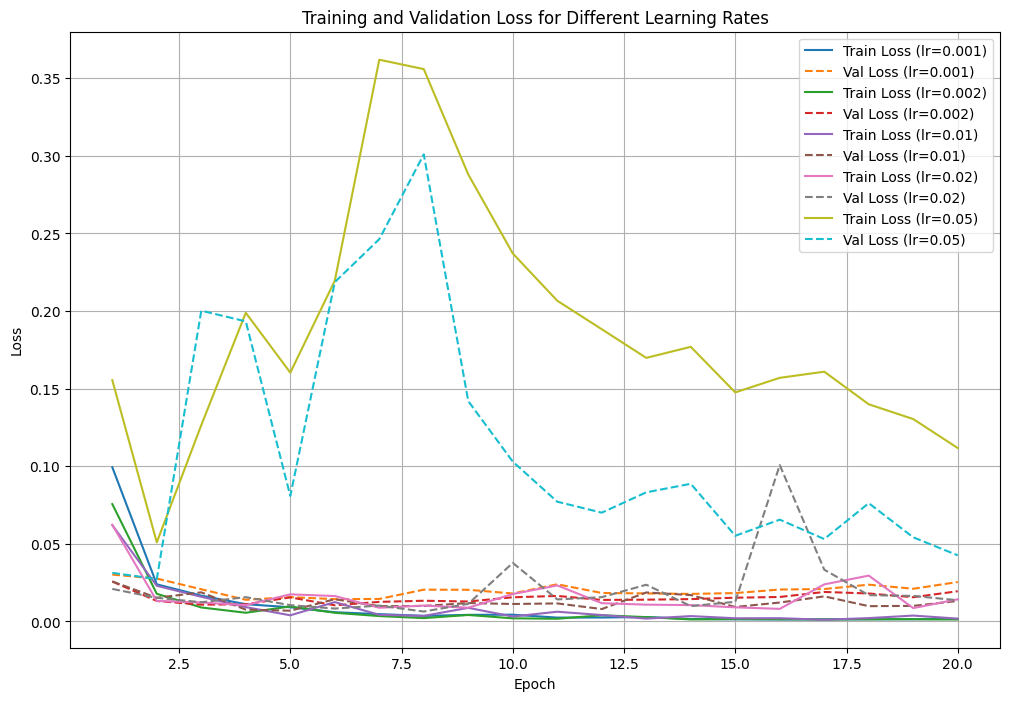


Testing some examples:


AttributeError: 'XSSDetector' object has no attribute 'predict'

In [8]:
# Run demonstration
if __name__ == "__main__":
    demo_detector()